In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt
from PIL import Image

def show_images(x):

    #given batch of images x, make a grid and convert to PIL
    x = x * 0.5 + 0.5 # map from [-1,1] to [0,1]
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) *255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im



def make_grid(images, size=64):

    #given list of PIL images, stack them together into a line
    output_im = Image.new("RGB", (size * len(images), size))

    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    
    return output_im


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from diffusers import StableDiffusionPipeline

model_id = "sd-dreambooth-library/mr-potato-head"

#load pipeline
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

c:\Users\TYC\Desktop\python code\hugging face\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...:  71%|███████▏  | 5/7 [00:00<00:00,  5.60it/s]An error occurred while trying to fetch C:\Users\TYC\.cache\huggingface\hub\models--sd-dreambooth-library--mr-potato-head\snapshots\34246b94acd8b96166e8d93eaded001c380a2d4e\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\TYC\.cache\huggingface\hub\models--sd-dreambooth-library--mr-potato-head\snapshots\34246b94acd8b96166e8d93eaded001c380a2d4e\unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  86%|████████▌ | 6/7 [00:01<00:00,  4.05it/s]An error occurred while trying to fetch C:\Users\TYC\.cache\huggingface\hub\models--sd-dr

100%|██████████| 50/50 [00:11<00:00,  4.44it/s]


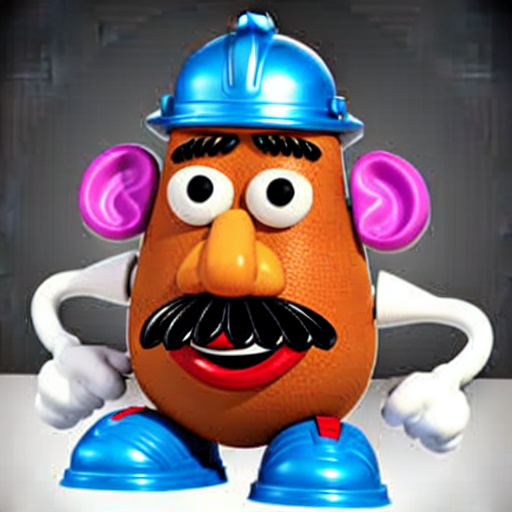

In [7]:
#prompt
prompt = " thor-dressed mr potato head "
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch C:\Users\TYC\.cache\huggingface\hub\models--johnowhitaker--ddpm-butterflies-32px\snapshots\ff99059aed185f6158729b8e9f2286c4b9c177f3: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\TYC\.cache\huggingface\hub\models--johnowhitaker--ddpm-butterflies-32px\snapshots\ff99059aed185f6158729b8e9f2286c4b9c177f3.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
100%|██████████| 1000/1000 [00:29<00:00, 34.36it/s]


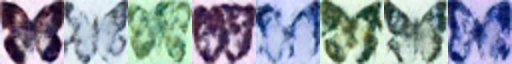

In [9]:
from diffusers import DDPMPipeline

#load butterfly pipeline
butterfly_pipeline = DDPMPipeline.from_pretrained("johnowhitaker/ddpm-butterflies-32px").to(device)

#8 images
images = butterfly_pipeline(batch_size=8).images

make_grid(images)

In [10]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

#from local folder
#dataset = load_dataset("imagefolder", data_dir="path/to/folder")

#32 pixel square image
image_size = 32

batch_size = 64

#define data augmentation
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)), #resize
        transforms.RandomHorizontalFlip(), #randomly flip
        transforms.ToTensor(), #convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]), #map to (-1, 1)
    ]
)

Repo card metadata block was not found. Setting CardData to empty.


In [11]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

X shape: torch.Size([8, 3, 32, 32])


C:\Users\TYC\AppData\Local\Temp\ipykernel_14576\4045639898.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


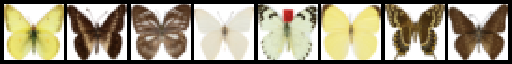

In [34]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

In [19]:
#scheduler handles adding noise to images, feeding noisy image to model, and use model prediction to remove noise
#scheduler determine how much noise is added at different timestep.
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps = 1000)

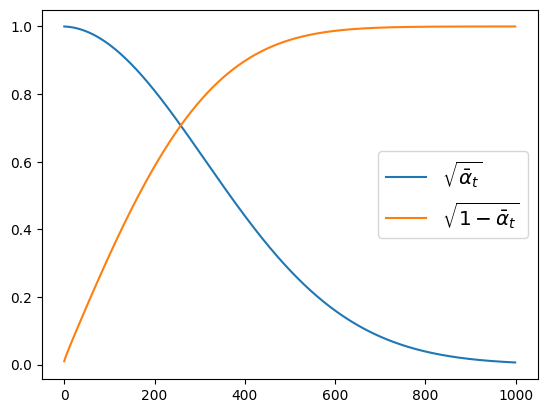

In [20]:
#DDPM forward process
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label =r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1-noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label =r"$\sqrt{1 - \bar{\alpha}_t}$")
plt.legend(fontsize="x-large")


Noisy X shape torch.Size([8, 3, 32, 32])


C:\Users\TYC\AppData\Local\Temp\ipykernel_14576\4045639898.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


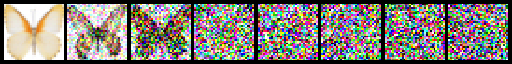

In [ ]:
#add noise in different amount 
#visualise image at different noise timesteps
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)


In [24]:
#Model (U-Net)
from diffusers import UNet2DModel

#create model
model = UNet2DModel(
    sample_size = image_size,
    in_channels = 3,
    out_channels = 3,
    layers_per_block = 2,
    block_out_channels = (64, 128, 128, 256), #as it downsamples, no of channels increases

    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),

    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",

    ),
)
model.to(device)

#higher resolution need more blocks
#attention layer only for low resolution layer to save memory


UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

In [25]:
with torch.no_grad():
    
    model_prediction = model(noisy_xb, timesteps).sample

model_prediction.shape

torch.Size([8, 3, 32, 32])

In [39]:
# create training loop
# run batch by batch and update model each step (AdamW)

#set noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

#training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):

        clean_images = batch["images"].to(device)

        #sample noise to add
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        #sample random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs, ), device=clean_images.device).long()

        #add noise to clean images according to noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        #get prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        #calculate loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        #update parameter
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")


        


c:\Users\TYC\Desktop\python code\hugging face\.venv\Lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch:5, loss: 0.15183561109006405
Epoch:10, loss: 0.11843160912394524
Epoch:15, loss: 0.09509950177744031
Epoch:20, loss: 0.08801860269159079
Epoch:25, loss: 0.07633551536127925
Epoch:30, loss: 0.08060794323682785


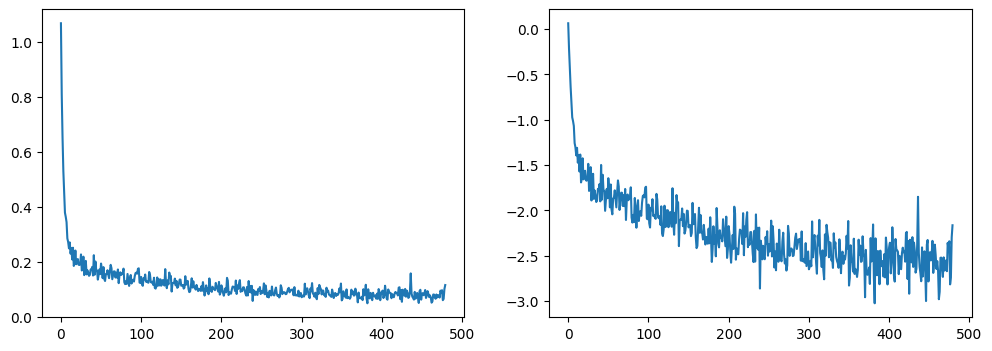

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(losses)
ax[1].plot(np.log(losses))
plt.show()

100%|██████████| 1000/1000 [00:32<00:00, 30.59it/s]


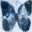

In [41]:
#generating image
#1. create pipeline
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

pipeline_output = image_pipe()
pipeline_output.images[0]

In [42]:
#save to a local folder
image_pipe.save_pretrained("my_first_diffusion_model")

C:\Users\TYC\AppData\Local\Temp\ipykernel_14576\4045639898.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


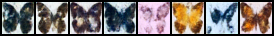

In [44]:
#2. write sampling loop
# 8 random images
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    #get model prediction
    with torch.no_grad():
        residual = model(sample, t).sample

    #update sample with step to update sample appropriately.
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

In [46]:
#push to hub
from huggingface_hub import get_full_repo_name

model_name = "my_first_diffusion_model"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'teohyc/my_first_diffusion_model'

In [47]:
#create model repository
from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id)
api = HfApi()

#upload schduler, unet and json
api.upload_folder(folder_path="my_first_diffusion_model/scheduler", path_in_repo="", repo_id=hub_model_id)
api.upload_folder(folder_path="my_first_diffusion_model/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="my_first_diffusion_model/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)


diffusion_pytorch_model.safetensors: 100%|██████████| 74.2M/74.2M [00:14<00:00, 5.02MB/s]


CommitInfo(commit_url='https://huggingface.co/teohyc/my_first_diffusion_model/commit/83fc27863220657953564accd5388736a42a9b05', commit_message='Upload model_index.json with huggingface_hub', commit_description='', oid='83fc27863220657953564accd5388736a42a9b05', pr_url=None, repo_url=RepoUrl('https://huggingface.co/teohyc/my_first_diffusion_model', endpoint='https://huggingface.co', repo_type='model', repo_id='teohyc/my_first_diffusion_model'), pr_revision=None, pr_num=None)

In [54]:
#create model card so can be found on hub
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute .

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image """

In [55]:
card = ModelCard(content)
card.push_to_hub(hub_model_id)

CommitInfo(commit_url='https://huggingface.co/teohyc/my_first_diffusion_model/commit/05139706631d2704ec4a902177ec2e571f505df2', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='05139706631d2704ec4a902177ec2e571f505df2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/teohyc/my_first_diffusion_model', endpoint='https://huggingface.co', repo_type='model', repo_id='teohyc/my_first_diffusion_model'), pr_revision=None, pr_num=None)